<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Working with Surface Observations in Siphon and MetPy</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="http://weather-geek.net/images/metar_what.png" alt="METAR" style="height: 200px;"></div>

### Questions
1. What's the best way to get surface station data from a THREDDS data server?
1. What's the best way to make a station plot of data?
1. How can I request a time series of data for a single station?

### Objectives
1. <a href="#ncss">Use the netCDF Subset Service (NCSS) to request a portion of the data</a>
2. <a href="#stationplot">Download data for a single time across stations and create a station plot</a>
3. <a href="#timeseries">Request a time series of data and plot</a>

<a name="ncss"></a>
## 1. Using NCSS to get point data

In [1]:
from siphon.catalog import TDSCatalog

# copied from the browser url box
metar_cat_url = ('http://thredds.ucar.edu/thredds/catalog/'
                 'irma/metar/catalog.xml?dataset=irma/metar/Metar_Station_Data_-_Irma_fc.cdmr')

# Parse the xml
catalog = TDSCatalog(metar_cat_url)

# what datasets are here?
print(list(catalog.datasets))

['Feature Collection']


In [2]:
metar_dataset = catalog.datasets['Feature Collection']

Once we've grabbed the "Feature Collection" dataset, we can request a subset of the data:

In [3]:
# Can safely ignore the warnings
ncss = metar_dataset.subset()

What variables do we have available?

In [4]:
ncss.variables

{'altimeter_setting',
 'dewpoint',
 'report',
 'sea_level_pressure',
 'sky_coverage',
 'temperature',
 'visibility',
 'wind_direction',
 'wind_gust',
 'wind_speed'}

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="stationplot"></a>
## 2. Making a station plot
 * Make new NCSS query
 * Request data closest to a time

In [5]:
from datetime import datetime

query = ncss.query()
query.lonlat_box(north=34, south=24, east=-80, west=-90)
query.time(datetime(2017, 9, 10, 12))
query.variables('temperature', 'dewpoint', 'altimeter_setting',
                'wind_speed', 'wind_direction', 'sky_coverage')
query.accept('csv')

var=altimeter_setting&var=temperature&var=wind_speed&var=sky_coverage&var=wind_direction&var=dewpoint&time=2017-09-10T12%3A00%3A00&west=-90&east=-80&south=24&north=34&accept=csv

In [6]:
# Get the data
data = ncss.get_data(query)
data

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/siphon/ncss.py:433: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  converters={'date': lambda s: parse_iso_date(s.decode('utf-8'))})


{'time': array([b'2017-09-10T13:00:00Z', b'2017-09-10T12:55:00Z',
        b'2017-09-10T12:53:00Z', b'2017-09-10T12:53:00Z',
        b'2017-09-10T12:53:00Z', b'2017-09-10T12:53:00Z',
        b'2017-09-10T12:53:00Z', b'2017-09-10T12:56:00Z',
        b'2017-09-10T12:56:00Z', b'2017-09-10T12:56:00Z',
        b'2017-09-10T12:56:00Z', b'2017-09-10T12:58:00Z',
        b'2017-09-10T12:58:00Z', b'2017-09-10T12:58:00Z',
        b'2017-09-10T12:58:00Z', b'2017-09-10T12:58:00Z',
        b'2017-09-10T12:58:00Z', b'2017-09-10T12:58:00Z',
        b'2017-09-10T12:58:00Z', b'2017-09-10T12:58:00Z',
        b'2017-09-10T12:58:00Z', b'2017-09-10T12:58:00Z',
        b'2017-09-10T12:58:00Z', b'2017-09-10T12:53:00Z',
        b'2017-09-10T12:53:00Z', b'2017-09-10T12:53:00Z',
        b'2017-09-10T12:53:00Z', b'2017-09-10T12:53:00Z',
        b'2017-09-10T12:58:00Z', b'2017-09-10T12:58:00Z',
        b'2017-09-10T12:58:00Z', b'2017-09-10T12:58:00Z',
        b'2017-09-10T12:56:00Z', b'2017-09-10T12:56:00Z',
      

Now we need to pull apart the data and perform some modifications, like converting winds to components and convert sky coverage percent to codes (octets) suitable for plotting.

In [7]:
import numpy as np

import metpy.calc as mpcalc
from metpy.units import units

# Since we used the CSV data, this is just a dictionary of arrays
lats = data['latitude']
lons = data['longitude']
tair = data['temperature']
dewp = data['dewpoint']
alt = data['altimeter_setting']

# Convert wind to components
u, v = mpcalc.wind_components(data['wind_speed'] * units.knots, data['wind_direction'] * units.degree)

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['sky_coverage'] / 100.
cloud_cover[np.isnan(cloud_cover)] = 10
cloud_cover = cloud_cover.astype(np.int)

# For some reason these come back as bytes instead of strings
stid = np.array([s.tostring().decode() for s in data['station']])

### Create the map using cartopy and MetPy!

One way to create station plots with MetPy is to create an instance of `StationPlot` and call various plot methods, like `plot_parameter`, to plot arrays of data at locations relative to the center point.

In addition to plotting values, `StationPlot` has support for plotting text strings, symbols, and plotting values using custom formatting.

Plotting symbols involves mapping integer values to various custom font glyphs in our custom weather symbols font. MetPy provides mappings for converting WMO codes to their appropriate symbol. The `sky_cover` function below is one such mapping.

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1833: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1833: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


TextCollection

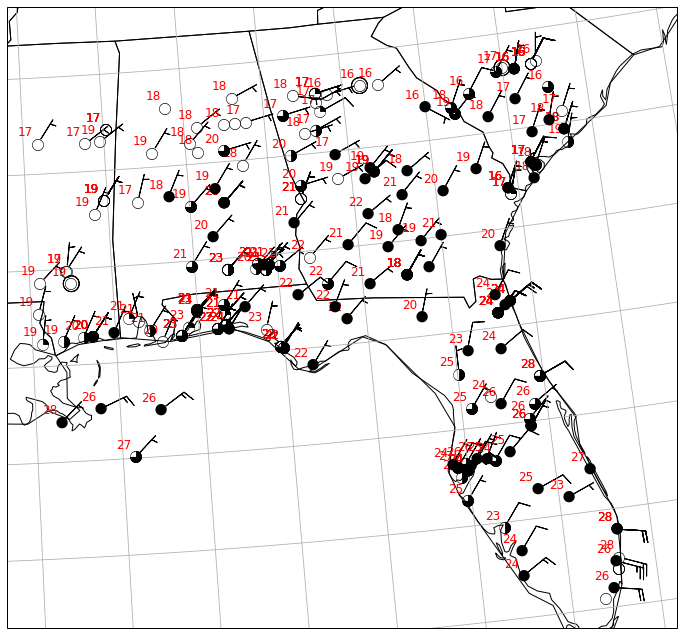

In [8]:
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from metpy.plots import StationPlot, sky_cover

# Set up a plot with map features
fig = plt.figure(figsize=(12, 12))
proj = ccrs.Stereographic(central_longitude=-95, central_latitude=35)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.coastlines(resolution='50m')
ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=12)
stationplot.plot_parameter('NW', tair, color='red')

# Add wind barbs
stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stationplot.plot_symbol('C', cloud_cover, sky_cover)

Notice how there are so many overlapping stations? There's a utility in MetPy to help with that: `reduce_point_density`. This returns a mask we can apply to data to filter the points.

In [9]:
# Project points so that we're filtering based on the way the stations are laid out on the map
proj = ccrs.Stereographic(central_longitude=-95, central_latitude=35)
xy = proj.transform_points(ccrs.PlateCarree(), lons, lats)

# Reduce point density so that there's only one point within a 200km circle
mask = mpcalc.reduce_point_density(xy, 200000)

Now we just plot with `arr[mask]` for every `arr` of data we use in plotting.

TextCollection

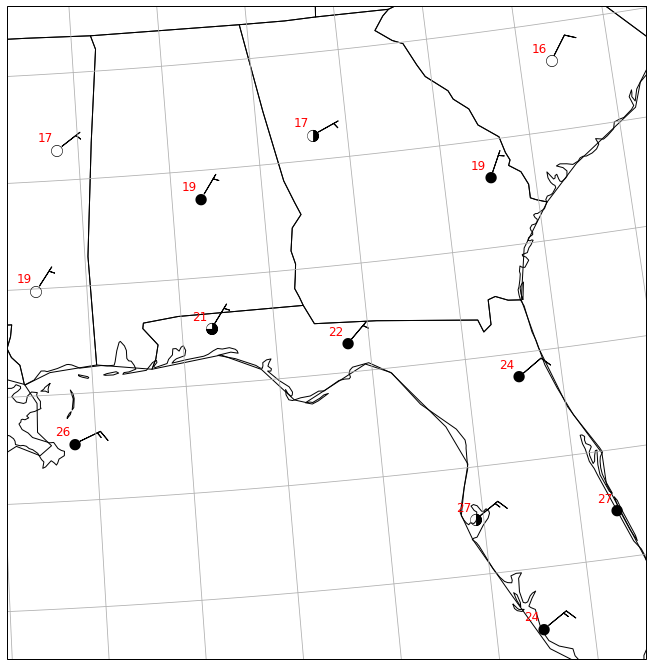

In [10]:
# Set up a plot with map features
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.coastlines(resolution='50m')
ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons[mask], lats[mask], transform=ccrs.PlateCarree(),
                          fontsize=12)
stationplot.plot_parameter('NW', tair[mask], color='red')
stationplot.plot_barb(u[mask], v[mask])
stationplot.plot_symbol('C', cloud_cover[mask], sky_cover)

More examples for MetPy Station Plots:
- [MetPy Examples](https://unidata.github.io/MetPy/latest/examples/index.html)
- [MetPy Symbol list](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html#metpy.plots.StationPlot.plot_symbol)

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
        <li>Modify the station plot (reproduced below) to include dewpoint, altimeter setting, as well as the station id. The station id can be added using the `plot_text` method on `StationPlot`.</li>
        <li>Re-mask the data to be a bit more finely spaced, say: 75km</li>
        <li>Bonus Points: Use the `formatter` argument to `plot_parameter` to only plot the 3 significant digits of altimeter setting. (Tens, ones, tenths)</li>
    </ul>
</div>

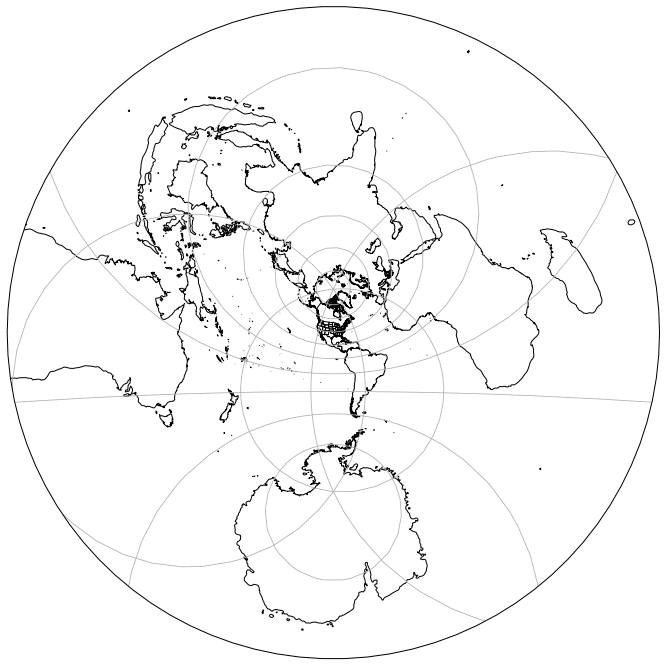

In [11]:
# Use reduce_point_density

# Set up a plot with map features
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.coastlines(resolution='50m')
ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points

# Plot dewpoint

# Plot altimeter setting--formatter can take a function that formats values

# Plot station id

TextCollection

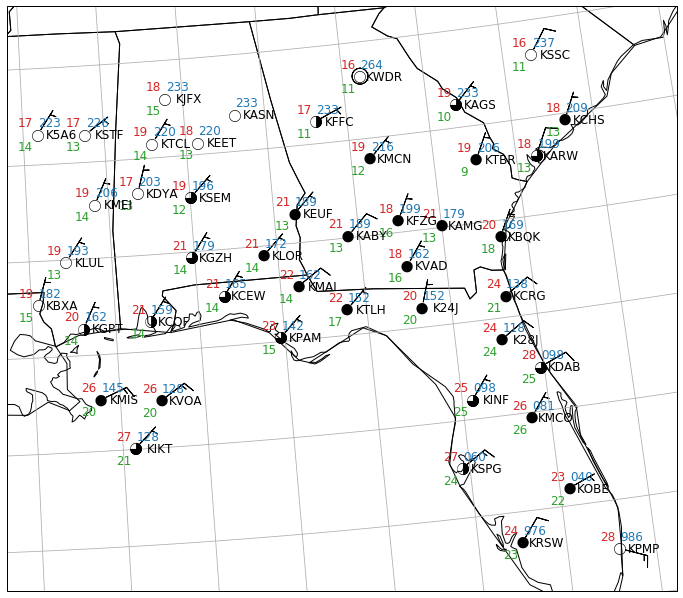

In [12]:
# %load solutions/reduce_density.py


# Cell content replaced by load magic replacement.
# Use reduce_point_density
mask = mpcalc.reduce_point_density(xy, 75000)

# Set up a plot with map features
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.coastlines(resolution='50m')
ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons[mask], lats[mask], transform=ccrs.PlateCarree(),
                          fontsize=12)
stationplot.plot_parameter('NW', tair[mask], color='tab:red')
stationplot.plot_barb(u[mask], v[mask])
stationplot.plot_symbol('C', cloud_cover[mask], sky_cover)

# Plot dewpoint
stationplot.plot_parameter('SW', dewp[mask], color='tab:green')

# Plot altimeter setting
stationplot.plot_parameter('NE', alt[mask], color='tab:blue',
                           formatter=lambda v: str(int(v * 10))[-3:])

# Plot station id
stationplot.plot_text((2, 0), stid[mask])

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="timeseries"></a>
## 3. Time Series request and plot
* Let's say we want the past days worth of data...
* ...for Boulder (i.e. the lat/lon)
* ...for the variables mean sea level pressure, air temperature, wind direction, and wind_speed

In [13]:
from datetime import timedelta

# define the time range we are interested in
end_time = datetime(2017, 9, 12, 0)
start_time = end_time - timedelta(days=2)

# build the query
query = ncss.query()
query.lonlat_point(-80.25, 25.8)
query.time_range(start_time, end_time)
query.variables('altimeter_setting', 'temperature', 'dewpoint',
                'wind_direction', 'wind_speed')
query.accept('csv')

var=altimeter_setting&var=temperature&var=wind_speed&var=wind_direction&var=dewpoint&time_start=2017-09-10T00%3A00%3A00&time_end=2017-09-12T00%3A00%3A00&longitude=-80.25&latitude=25.8&accept=csv

### Let's get the data!

In [14]:
data = ncss.get_data(query)

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/siphon/ncss.py:433: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  converters={'date': lambda s: parse_iso_date(s.decode('utf-8'))})


In [15]:
print(list(data.keys()))

['time', 'station', 'latitude', 'longitude', 'altimeter_setting', 'temperature', 'wind_speed', 'wind_direction', 'dewpoint']


### What station did we get?

In [16]:
station_id = data['station'][0].tostring()
print(station_id)

b'KMIA'


That indicates that we have a Python `bytes` object, containing the 0-255 values corresponding to `'K', 'M', 'I', 'A'`. We can `decode` those bytes into a string:

In [17]:
station_id = station_id.decode('ascii')
print(station_id)

KMIA


Let's get the time into datetime objects. We see we have an array with byte strings in it, like station id above.

In [18]:
data['time']

array([b'2017-09-10T00:13:00Z', b'2017-09-10T00:19:00Z',
       b'2017-09-10T00:19:00Z', b'2017-09-10T00:44:00Z',
       b'2017-09-10T00:50:00Z', b'2017-09-10T00:53:00Z',
       b'2017-09-10T00:56:00Z', b'2017-09-10T01:08:00Z',
       b'2017-09-10T01:26:00Z', b'2017-09-10T01:53:00Z',
       b'2017-09-10T02:53:00Z', b'2017-09-10T03:28:00Z',
       b'2017-09-10T03:40:00Z', b'2017-09-10T03:53:00Z',
       b'2017-09-10T04:53:00Z', b'2017-09-10T05:44:00Z',
       b'2017-09-10T05:53:00Z', b'2017-09-10T06:07:00Z',
       b'2017-09-10T06:53:00Z', b'2017-09-10T07:53:00Z',
       b'2017-09-10T08:21:00Z', b'2017-09-10T08:41:00Z',
       b'2017-09-10T08:53:00Z', b'2017-09-10T09:53:00Z',
       b'2017-09-10T10:28:00Z', b'2017-09-10T10:41:00Z',
       b'2017-09-10T10:53:00Z', b'2017-09-10T11:02:00Z',
       b'2017-09-10T11:16:00Z', b'2017-09-10T11:33:00Z',
       b'2017-09-10T11:53:00Z', b'2017-09-10T12:07:00Z',
       b'2017-09-10T12:16:00Z', b'2017-09-10T12:31:00Z',
       b'2017-09-10T12:53:00Z',

So we can use a list comprehension to turn this into a list of date time objects:

In [19]:
time = [datetime.strptime(s.decode('ascii'), '%Y-%m-%dT%H:%M:%SZ') for s in data['time']]

### Now for the obligatory time series plot...

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


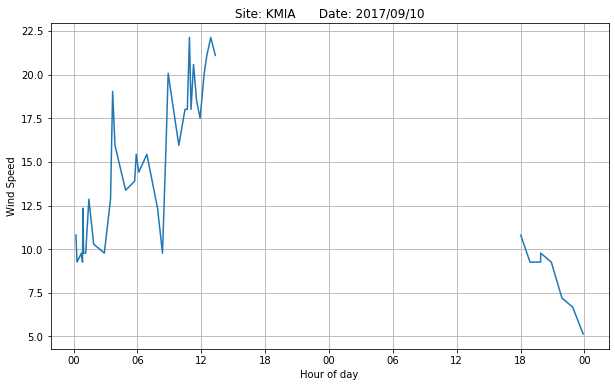

In [20]:
from matplotlib.dates import DateFormatter, AutoDateLocator

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, data['wind_speed'], color='tab:blue')

ax.set_title(f'Site: {station_id}      Date: {time[0]:%Y/%m/%d}')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Wind Speed')
ax.grid(True)

# Improve on the default ticking
locator = AutoDateLocator()
hoursFmt = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(hoursFmt)

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
        <li>Pick a different location</li>
        <li>Plot temperature and dewpoint together on the same plot</li>
    </ul>
</div>

In [21]:
# Your code goes here


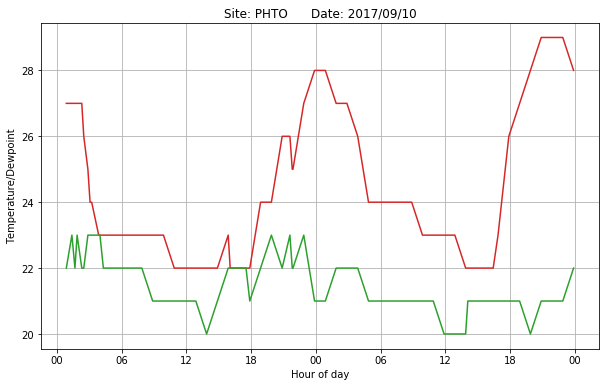

In [22]:
# %load solutions/time_series.py

# Cell content replaced by load magic replacement.
# define the time range we are interested in
end_time = datetime(2017, 9, 12, 0)
start_time = end_time - timedelta(days=2)

# build the query
query = ncss.query()
query.lonlat_point(-155.1, 19.7)
query.time_range(start_time, end_time)
query.variables('altimeter_setting', 'temperature', 'dewpoint',
                'wind_direction', 'wind_speed')
query.accept('csv')

data = ncss.get_data(query)

station_id = data['station'][0].tostring()
station_id = station_id.decode('ascii')

time = [datetime.strptime(s.decode('ascii'), '%Y-%m-%dT%H:%M:%SZ') for s in data['time']]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, data['temperature'], color='tab:red')
ax.plot(time, data['dewpoint'], color='tab:green')

ax.set_title(f'Site: {station_id}      Date: {time[0]:%Y/%m/%d}')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Temperature/Dewpoint')
ax.grid(True)

# Improve on the default ticking
locator = AutoDateLocator()
hoursFmt = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(hoursFmt)

<a href="#top">Top</a>
<hr style="height:2px;">